In [16]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onrik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python


### 预处理

In [17]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [19]:
df = pd.read_excel("C:/Users/onrik\\report\\0203_LDA\\Euronews 가공_0329.xlsx")
df.columns = ['title','date','content']
df.head()

,title,date,content
0,Facial recognition: Clearview AI breaks EU dat...,2021-12-16,France has threatened to fine the facial reco...
1,Time to get serious on European health data-sh...,2021-12-13,The views and opinions expressed in this arti...
2,These are the vital skills you’ll need to succ...,2021-11-28,Digital technologies are transforming the way ...
3,WhatsApp rewrites its Europe privacy policy af...,2021-11-22,WhatsApp has rewritten its privacy policy for ...
4,What is artificial intelligence and how does t...,2021-11-09,Receiving a film recommendation on your favou...


In [20]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm") 
# nlp = spacy.load('zh_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

# print(data_lemmatized[:1])

In [24]:
data_lemmatized

[['threaten',
  'fine',
  'facial_recognition',
  'company',
  'collect',
  'citizen',
  'datum',
  'french',
  'datum',
  'protection',
  'watchdog',
  'cnil',
  'say',
  'american',
  'company',
  'collect',
  'thousand',
  'photo',
  'french',
  'citizen',
  'consent',
  'authority',
  'order',
  'clearview',
  'delete',
  'database',
  'image',
  'month',
  'stop',
  'collect',
  'data',
  'cnil',
  'say',
  'statement',
  'company',
  'violate',
  'european',
  'union',
  'strict',
  'general',
  'datum',
  'protection',
  'regulation',
  'gdpr',
  'collection',
  'biometric',
  'datum',
  'carry',
  'legal',
  'basis',
  'watchdog',
  'say',
  'cite',
  'fail',
  'address',
  'right',
  'individual',
  'include',
  'request',
  'access',
  'datum',
  'cnil',
  'add',
  'launch',
  'investigation',
  'receive',
  'complaint',
  'clearview',
  'software',
  'watchdog',
  'say',
  'permit',
  'fine',
  'company',
  'datum',
  'delete',
  'month',
  'time',
  'clearview',
  'state',


### TF-IDF

In [25]:
### Term-Frequency
from collections import Counter
words = ''
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    words += t
words = words.split()
counts = Counter(words)
counts

Counter({'threaten': 16,
         'fine': 83,
         'facial_recognition': 26,
         'company': 320,
         'collect': 65,
         'citizen': 72,
         'datum': 788,
         'french': 17,
         'protection': 183,
         'watchdog': 23,
         'cnil': 12,
         'say': 412,
         'american': 11,
         'thousand': 7,
         'photo': 25,
         'consent': 53,
         'authority': 64,
         'order': 27,
         'clearview': 5,
         'delete': 16,
         'database': 6,
         'image': 9,
         'month': 41,
         'stop': 21,
         'data': 72,
         'statement': 35,
         'violate': 7,
         'european': 162,
         'union': 9,
         'strict': 24,
         'general': 61,
         'regulation': 191,
         'gdpr': 209,
         'collection': 12,
         'biometric': 7,
         'carry': 5,
         'legal': 42,
         'basis': 12,
         'cite': 9,
         'fail': 27,
         'address': 32,
         'right': 96,
        

In [26]:
vocab = sorted(counts, key=counts.get, reverse=True)
tf_df = []
for voca in vocab:
    tf_df.append({'word': voca, 'term frequency': counts[voca]})
tf_df = pd.DataFrame(tf_df)
tf_df.head(10)

,word,term frequency
0,datum,788
1,say,412
2,company,320
3,user,276
4,privacy,230
5,gdpr,209
6,regulation,191
7,protection,183
8,facebook,170
9,european,162


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
contents_tfidf = []
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    contents_tfidf.append(t)
vectorizer = TfidfVectorizer(stop_words='english', max_features= 100)
X = vectorizer.fit_transform(contents_tfidf)

# # TF-IDF 행렬의 크기 확인
# print('TF-IDF 행렬의 크기 :',X.shape)
tf_idfdict=  vectorizer.get_feature_names()
data_array = X.toarray()
data_tdidf = pd.DataFrame(data_array, columns=tf_idfdict)
data_tdidf


,access,account,ad,add,allow,app,ask,authority,base,big,...,time,track,use,user,want,way,website,work,world,year
0,0.131506,0.000000,0.0,0.120577,0.000000,0.000000,0.000000,0.120577,0.057131,0.000000,...,0.050443,0.000000,0.045483,0.083343,0.000000,0.000000,0.0,0.000000,0.057131,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.033868,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032771,0.000000,0.000000,0.051622,0.027530,0.0,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.084645,0.039079,0.049994,0.042322,0.000000,0.000000,0.087050,...,0.000000,0.000000,0.191572,0.029253,0.038100,0.325107,0.0,0.312633,0.040106,0.108809
3,0.000000,0.000000,0.0,0.091959,0.000000,0.000000,0.000000,0.091959,0.087142,0.094572,...,0.000000,0.000000,0.138750,0.254249,0.000000,0.176599,0.0,0.000000,0.000000,0.078808
4,0.000000,0.000000,0.0,0.000000,0.038440,0.000000,0.041630,0.041630,0.118348,0.000000,...,0.034832,0.047583,0.345469,0.028775,0.000000,0.119920,0.0,0.076880,0.039449,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.000000,0.178816,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.104632,0.272551,0.000000,0.0,0.000000,0.143448,0.129728
94,0.000000,0.000000,0.0,0.000000,0.053490,0.136861,0.000000,0.115859,0.054895,0.059576,...,0.096939,0.000000,0.043703,0.280288,0.000000,0.000000,0.0,0.000000,0.000000,0.099290
95,0.070236,0.000000,0.0,0.000000,0.000000,0.076073,0.000000,0.000000,0.030513,0.066229,...,0.026941,0.000000,0.121460,0.000000,0.173926,0.000000,0.0,0.059465,0.000000,0.000000
96,0.059646,0.000000,0.0,0.109378,0.050498,0.000000,0.000000,0.000000,0.051825,0.000000,...,0.000000,0.000000,0.123775,0.302411,0.000000,0.052513,0.0,0.000000,0.000000,0.000000


In [28]:
def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()

    matrix = vectorizer.fit_transform(text_series).todense()

    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())


    return matrix_df.sum(axis=0).sort_values(ascending=False)

# # Create Corpus for TD-IDF analysis 
text_df = pd.DataFrame()
text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
text_to_tfidf = [",".join(text) for text in text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(text_to_tfidf)
topwords.to_excel("topwords.xlsx")
topwords_50 = topwords[:50]
topwords_50.to_excel("Euronews_topwords_tf_idf_50.xlsx")

In [29]:
topwords

datum            11.884251
say               6.726600
user              6.036643
company           5.620153
facebook          5.346016
                   ...    
dignity           0.026611
differentiate     0.026611
speeche           0.026611
deliberation      0.026611
movie             0.026611
Length: 4097, dtype: float64

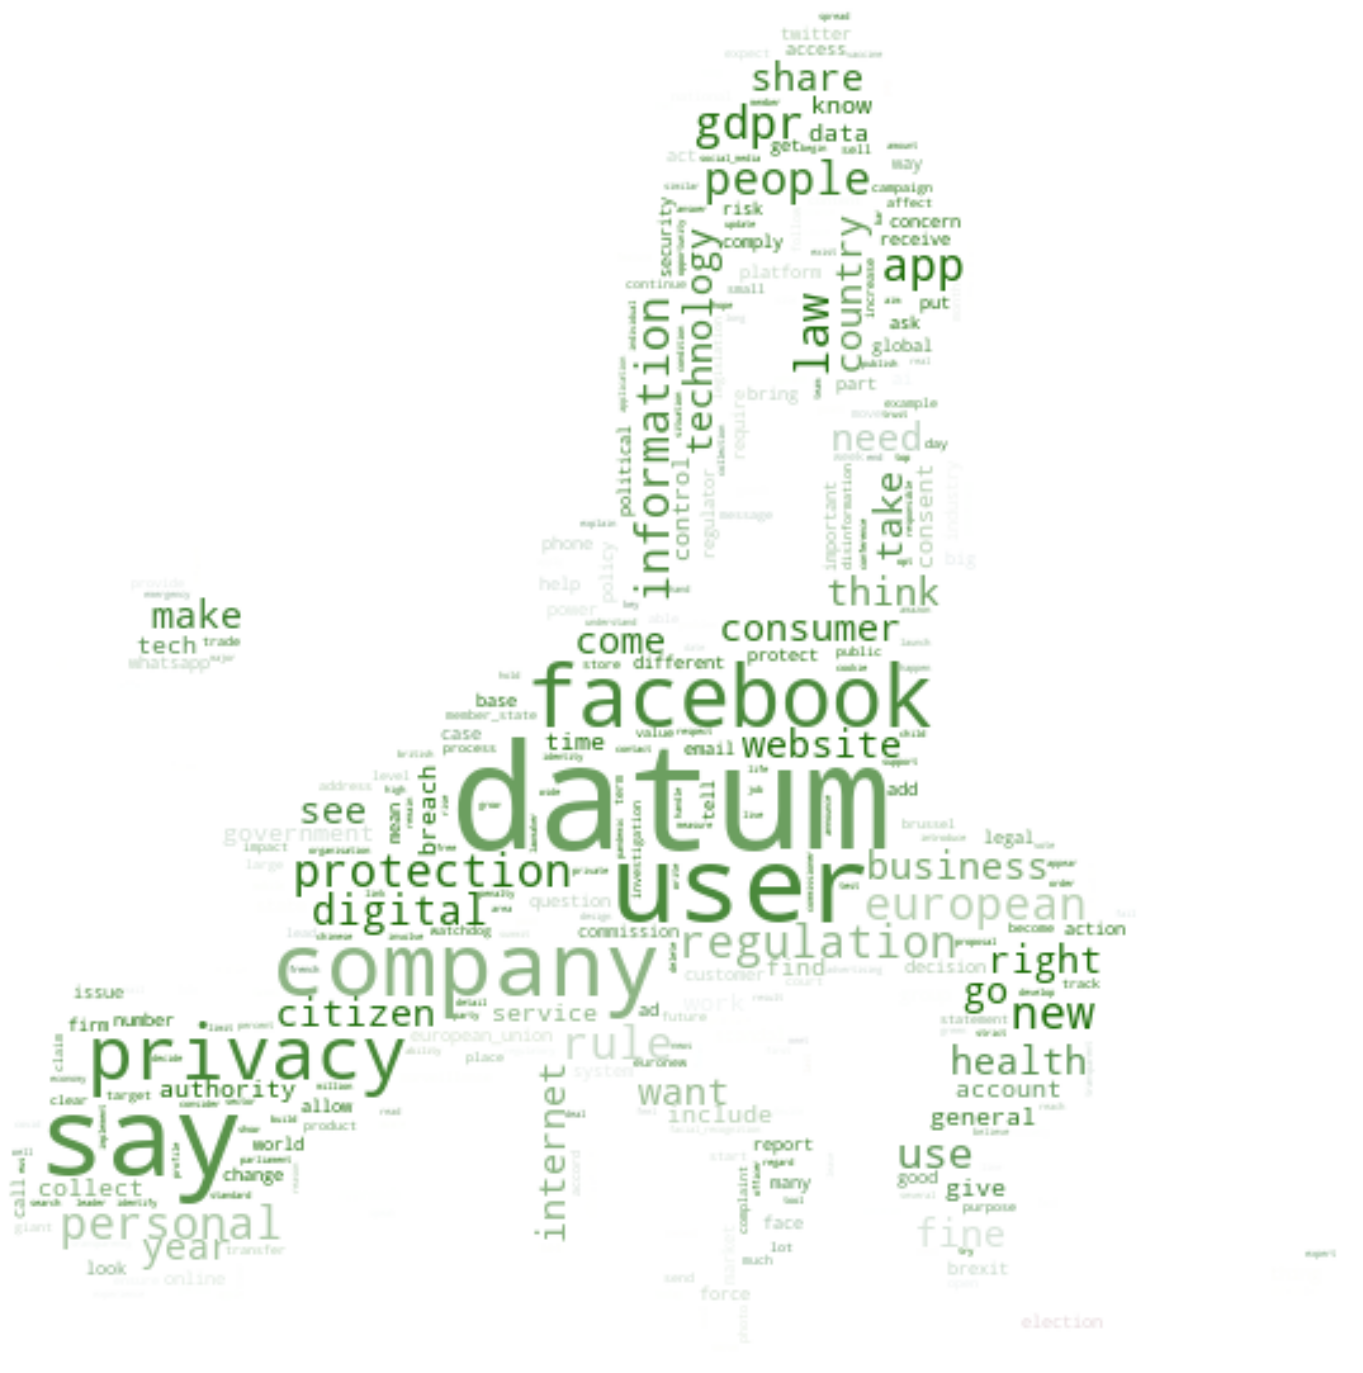

In [30]:
# Importing word cloud
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from PIL import Image

## Creating a masked wordcloud using TD-IDF
fig, ax = plt.subplots(figsize=(25,25))
custom_mask = np.array(Image.open("EU3.jpg"))
w = WordCloud(background_color = 'white',
              width=800,height=600,
              mask = custom_mask,
              mode='RGBA',
              max_words=2000).fit_words(topwords)
image_colors = ImageColorGenerator(custom_mask)
w.recolor(color_func = image_colors)
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('Euronews_TFIDF_Wordcloud.png', dpi=800)

### LDA

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 5), (28, 1), (29, 5), (30, 5), (31, 4), (32, 1), (33, 1), (34, 1), (35, 12), (36, 2), (37, 2), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 2), (45, 2), (46, 12), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 4), (63, 4), (64, 1), (65, 2), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 5), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 4), (107, 1), (108, 2), (109, 1), (110, 

In [32]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet'  # update this path
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
import os
os.environ.update({'MALLET_HOME':r'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/'})

mallet_path = 'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path


# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(0,
  [('datum', 0.09566294919454771),
   ('gdpr', 0.05204460966542751),
   ('protection', 0.04560099132589839),
   ('personal', 0.026517967781908302),
   ('rule', 0.024783147459727387),
   ('regulation', 0.021065675340768277),
   ('fine', 0.020817843866171002),
   ('company', 0.020074349442379184),
   ('privacy', 0.01858736059479554),
   ('authority', 0.01660470879801735)]),
 (1,
  [('facebook', 0.04770848985725019),
   ('political', 0.017655897821187077),
   ('year', 0.015026296018031555),
   ('scandal', 0.014650638617580767),
   ('issue', 0.014650638617580767),
   ('campaign', 0.01389932381667919),
   ('report', 0.01314800901577761),
   ('question', 0.012772351615326822),
   ('address', 0.012021036814425245),
   ('giant', 0.011269722013523666)]),
 (2,
  [('datum', 0.0441049293744595),
   ('make', 0.030556356298645143),
   ('digital', 0.029403286249639667),
   ('people', 0.027097146151628712),
   ('european', 0.025367541078120497),
   ('health', 0.021620063418852694),
   ('work', 0.

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

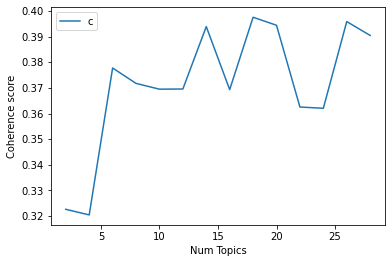

In [36]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
model_list

Num Topics = 2  has Coherence Value of 0.3226
Num Topics = 4  has Coherence Value of 0.3204
Num Topics = 6  has Coherence Value of 0.3778
Num Topics = 8  has Coherence Value of 0.3718
Num Topics = 10  has Coherence Value of 0.3695
Num Topics = 12  has Coherence Value of 0.3696
Num Topics = 14  has Coherence Value of 0.3939
Num Topics = 16  has Coherence Value of 0.3693
Num Topics = 18  has Coherence Value of 0.3976
Num Topics = 20  has Coherence Value of 0.3944
Num Topics = 22  has Coherence Value of 0.3625
Num Topics = 24  has Coherence Value of 0.362
Num Topics = 26  has Coherence Value of 0.3959
Num Topics = 28  has Coherence Value of 0.3905


In [38]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.027*"technology" + 0.018*"country" + 0.014*"system" + 0.012*"european" + '
  '0.012*"risk" + 0.011*"citizen" + 0.010*"power" + 0.009*"government" + '
  '0.009*"trade" + 0.009*"time" + 0.009*"call" + 0.008*"approach" + '
  '0.007*"commission" + 0.007*"member_state" + 0.007*"world" + '
  '0.007*"european_union" + 0.007*"open" + 0.007*"surveillance" + 0.007*"base" '
  '+ 0.007*"develop"'),
 (1,
  '0.115*"datum" + 0.046*"gdpr" + 0.037*"protection" + 0.024*"privacy" + '
  '0.021*"personal" + 0.019*"regulation" + 0.018*"fine" + 0.017*"rule" + '
  '0.015*"data" + 0.015*"information" + 0.014*"facebook" + 0.014*"authority" + '
  '0.013*"general" + 0.011*"case" + 0.011*"breach" + 0.010*"policy" + '
  '0.010*"comply" + 0.009*"legal" + 0.009*"regulator" + 0.008*"decision"'),
 (2,
  '0.032*"facebook" + 0.018*"datum" + 0.016*"year" + 0.014*"firm" + '
  '0.013*"user" + 0.013*"political" + 0.013*"report" + 0.011*"scandal" + '
  '0.011*"question" + 0.011*"platform" + 0.010*"regulation" + 0.01

In [39]:
ldadf = []
for i in range(len(optimal_model.print_topics(num_words= 20))):
    topic = optimal_model.print_topics(num_words= 20)[i]
    topic_num = 'topic' + ' ' + str(i+1)
    for j in range(len(topic[1].split(" + "))):
        term = topic[1].split(" + ")[j].split("*")[1][1:-1]
        ldanum = topic[1].split(" + ")[j].split("*")[0]
        ldadf.append({"topic": topic_num, 'term':term, 'lda_num':ldanum})
ldadf = pd.DataFrame(ldadf)
print(len(ldadf), ldadf.term.nunique())
ldadf

120 104


,topic,term,lda_num
0,topic 1,technology,0.027
1,topic 1,country,0.018
2,topic 1,system,0.014
3,topic 1,european,0.012
4,topic 1,risk,0.012
...,...,...,...
115,topic 6,concern,0.009
116,topic 6,month,0.009
117,topic 6,statement,0.009
118,topic 6,phone,0.008


In [40]:
ldadf.to_excel("Euronews LDAdf_final2_6.xlsx", index=False)

In [41]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3252,"datum, gdpr, protection, privacy, personal, re...",France has threatened to fine the facial reco...
1,1,4.0,0.4365,"datum, digital, european, make, business, peop...",The views and opinions expressed in this arti...
2,2,4.0,0.5548,"datum, digital, european, make, business, peop...",Digital technologies are transforming the way ...
3,3,1.0,0.4697,"datum, gdpr, protection, privacy, personal, re...",WhatsApp has rewritten its privacy policy for ...
4,4,0.0,0.4651,"technology, country, system, european, risk, c...",Receiving a film recommendation on your favou...
5,5,4.0,0.3290,"datum, digital, european, make, business, peop...",The European Union wants its Artificial Intel...
6,6,0.0,0.5685,"technology, country, system, european, risk, c...",Marking a new chapter in their rebooted relat...
7,7,5.0,0.3462,"user, privacy, app, datum, people, include, in...",Lithuanias defence ministry has advised people...
8,8,3.0,0.3968,"company, law, consumer, tech, internet, change...",Children in China will only be able to access ...
9,9,1.0,0.5648,"datum, gdpr, protection, privacy, personal, re...",Irelands Data Protection Commission (DPC) has ...


In [43]:
df_dominant_topic.to_excel("Euronews_토픽별docu.xlsx",index=False)

### NER

In [26]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
def NER(lst):
    doc = nlp(lst)
    NERlst = []
    for X in doc.ents:
    #     NERlst.append((X.text, X.label_))
        if X.label_ == 'ORG':
            NERlst.append(X.text)

    return NERlst
qq =  df

qq['content'] = data_words_nostops
nlpdf = qq[['content']]
de_doc = []
for i in range(len(data_words_nostops)):
    t = ' '.join(data_words_nostops[i])
    de_doc.append(t)
qq['content'] = de_doc
nlpdf = qq[['content']]    
nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))
nlpdf

<ipython-input-26-939e1312cae3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))


,content,NER result
0,france threatened fine facial recognition comp...,"[cnil, american company, european unions, euro..."
1,views opinions expressed article author one co...,"[healthcare, eu health data space, eu health d..."
2,digital technologies transforming way work rap...,"[amazon, harvard business review]"
3,whatsapp rewritten privacy policy european use...,"[detail meta, european union, meta whatsapp, i..."
4,receiving film recommendation favourite video ...,"[edri, netherlands finland commission, axel, e..."
...,...,...
58,eu citizens tracked ad tech companies visit go...,"[eu government, eu, eu citizens]"
59,office thats responsible enforcing european da...,"[ireland data protection commission, federal t..."
60,northern ireland backstop continuing thorn the...,"[congress, un, un, congress, microsoft]"
61,frances regulatory body dealing data privacy f...,"[national commission, eu major new data]"


In [27]:
from nltk.probability import FreqDist
NERll = nlpdf['NER result'].sum()
fdist = FreqDist(NERll)
top_20 = fdist.most_common(20)
top_20

[('european commission', 40),
 ('european union', 27),
 ('congress', 5),
 ('irelands data protection commission', 3),
 ('eu data protection', 3),
 ('european data protection board', 3),
 ('airbus', 3),
 ('wto', 3),
 ('ireland data protection commission', 3),
 ('kremlin', 3),
 ('eu health data space', 2),
 ('amazon', 2),
 ('data protection commission', 2),
 ('max', 2),
 ('eu court', 2),
 ('irish data protection commission', 2),
 ('von der leyen', 2),
 ('android', 2),
 ('eu general data protection', 2),
 ('general data protection', 2)]